In [45]:
import pymatgen as pmg
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.core.periodic_table import Element
from pymatgen.electronic_structure.core import Spin, Orbital
from pymatgen.electronic_structure.dos import Dos, DOS
import functools

from matplotlib.pyplot import figure

import matplotlib.pyplot as pyplot
from scipy.integrate import trapz, simps

def integrate(axis, line_idx, start, end, label=None):
    """Integrates the given DoS data"""
    line = axis.get_lines()[line_idx]
    x = line.get_xdata()[start:end]
    y = line.get_ydata()[start:end]
    pyplot.plot(x,y, label=label)
    pyplot.legend()
    return(simps(y,x))

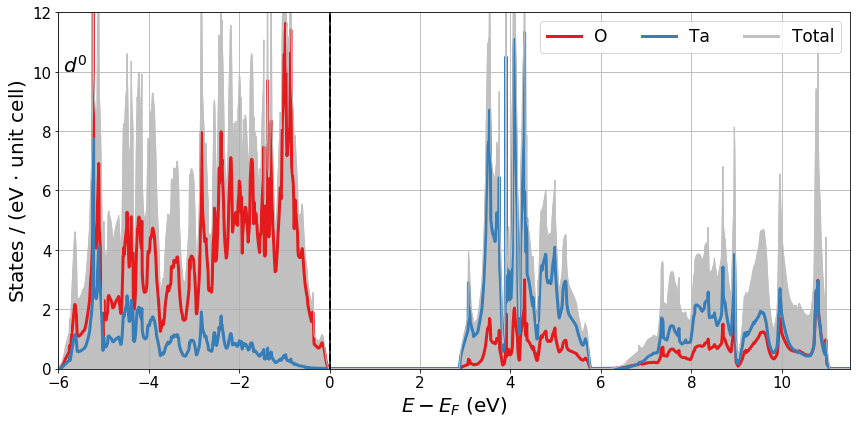

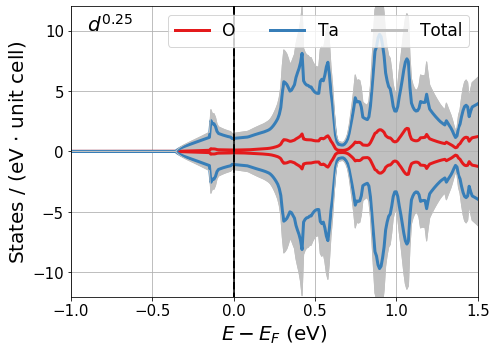

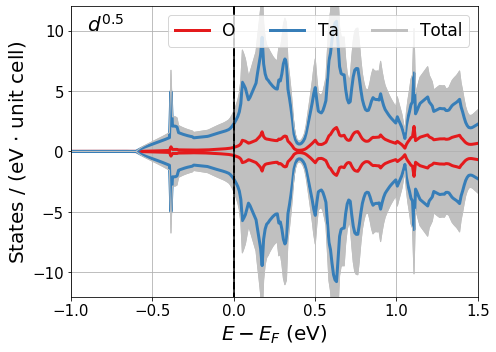

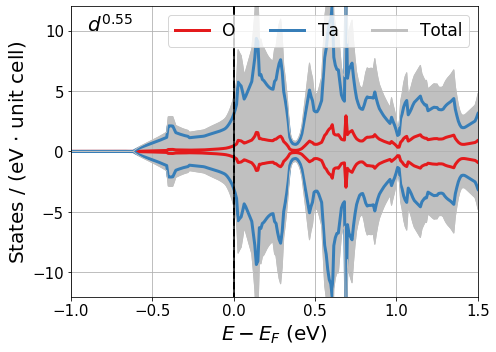

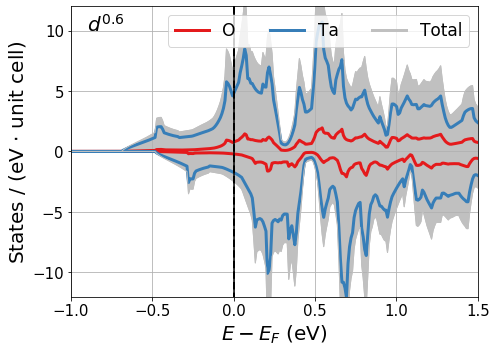

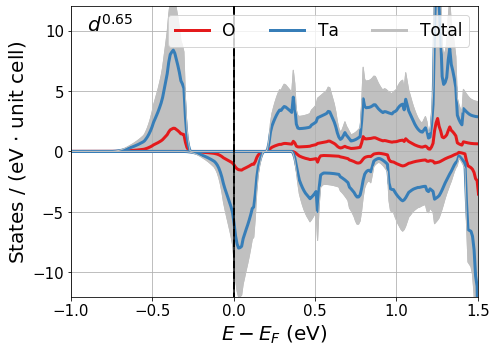

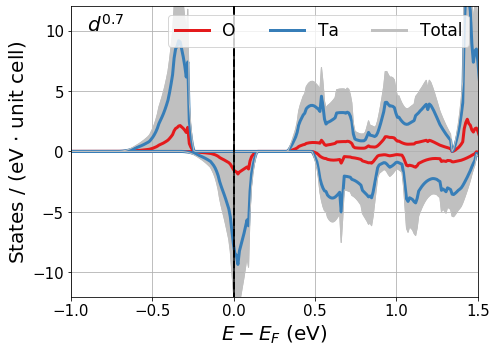

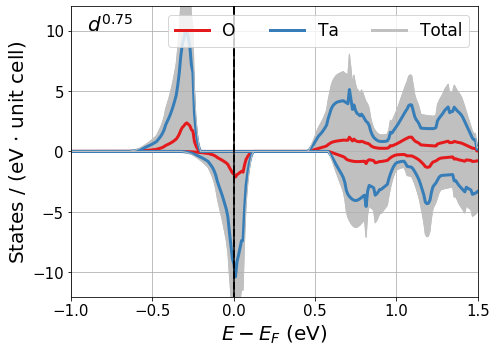

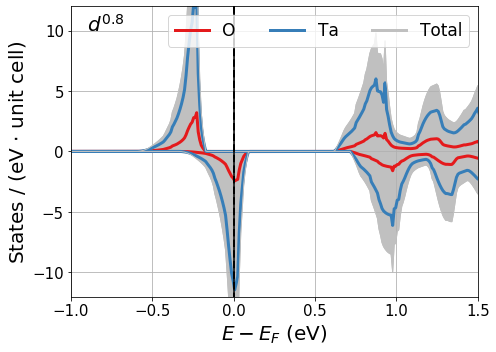

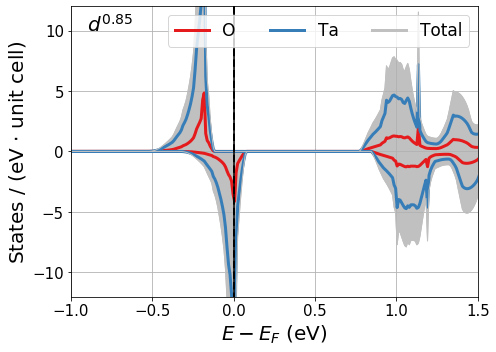

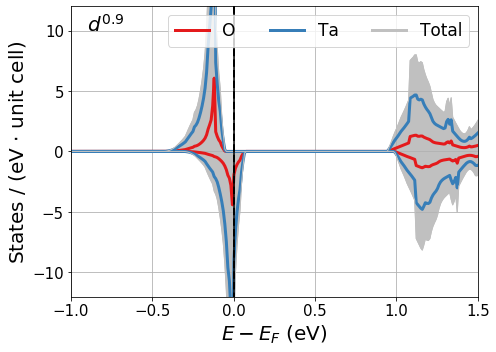

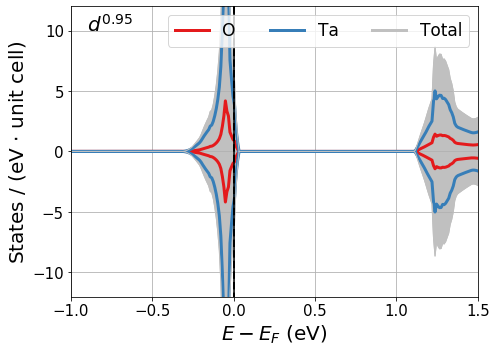

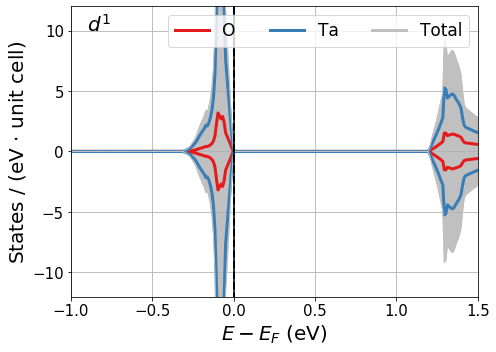

In [33]:
WIDTH = 7
HEIGHT = 5

BY_ELEMENT = ["Ta", "O"]
BY_SITE = []
ORBITALS_LS = [[4, 5, 6, 7, 8]] #desired orbitals corresponding to sites listed

PREFIX = "../../elec_dos/vasprun"
SUFFIX = ".xml"
ITERS_1 = ["d0", "d025", "d05", "d055", "d06", "d065", "d07", "d075", "d08", "d085", "d09", "d095", "d1"]
ITERS_2 = ['']
LABELS_1 = ['$d^{0}$','$d^{0.25}$','$d^{0.5}$','$d^{0.55}$','$d^{0.6}$','$d^{0.65}$','$d^{0.7}$',
                 '$d^{0.75}$','$d^{0.8}$','$d^{0.85}$','$d^{0.9}$','$d^{0.95}$','$d^{1}$']
LABELS_2 = ITERS_2
LABEL_PREFIX = ""
XLIMS = [[-6,11.5]] + [[-1,1.5]]*20
YLIMS = [[-12,12]]*20
LABEL_FONT = 20

axes = []

for i, iter_1 in enumerate(ITERS_1):
    for j, iter_2 in enumerate(ITERS_2):
        
        if len(iter_2) != 0:
            label = f'{iter_1}-{iter_2}'
        else:
            label = f'{iter_1}'
        
            # Extract dos from vasprun
        vr = Vasprun(f'{PREFIX}-{label}{SUFFIX}')
        cdos = vr.complete_dos
        tdos = vr.tdos
        
        dplt = DosPlotter()

            # Add total dos
        dplt.add_dos("Total", tdos)
        
            # Add site doss
        pdoss = cdos.pdos
        for site_idx, orbitals in zip(BY_SITE, ORBITALS_LS):
            site = cdos.structure[site_idx]
            elem = site.species.elements[0]
            efermi = cdos.efermi
            energies = cdos.energies
            for spin, spin_label in [(Spin.up, 'up'), (Spin.down, 'down')]:
                spin_doss = (pdoss[site][Orbital(orb_num)][spin] for orb_num in orbitals)
                
                dplt.add_dos(f'{elem}-{spin_label}', 
                             Dos(efermi, energies, {spin: sum(spin_doss)}))
                
        #         if DOS_TYPE == 'site':
        #             for site_idx in SITES:
        #                 site = cdos.structure[site_idx]
        #                 elem = cdos.structure[2].species.elements[0]
        #                 dos = cdos.get_site_dos()
        #                 dplt.add_dos(elem, dos)

            # Add element dos
        elem_doss = cdos.get_element_dos()
        for element in BY_ELEMENT:
            dplt.add_dos(element, elem_doss[Element(element)])

        
            
            # Customize plot
        dos_plot = dplt.get_plot()
        dos_plot.xlim(XLIMS[i])
        dos_plot.ylim(YLIMS[i])
        dos_plot.axvline(x=0, color='k', linestyle='-')
        dos_plot.grid(1)

            # Make total line grey and filled in
        totLine = dos_plot.gca().get_lines()[2]
        totLine.set_color('silver')

        dos_plot.legend(loc='upper right', ncol=6, fontsize=LABEL_FONT-3) #keep line thick in legend

        totLine.set_linewidth(1)   

        totX = totLine.get_xdata()
        totY = totLine.get_ydata()

        dos_plot.fill_between(totX, totY, where=totY>=-totY, interpolate=True, color='silver')
        dos_plot.fill_between(totX, totY, where=totY<=-totY, interpolate=True, color='silver')


            # Add a label to bottom right
        dos_plot.text(XLIMS[i][0]+0.1, YLIMS[i][1]-2, LABEL_PREFIX + LABELS_1[i], fontsize=LABEL_FONT)

            # Chance font size
        dos_plot.gca().xaxis.label.set_fontsize(LABEL_FONT)
        dos_plot.gca().yaxis.label.set_fontsize(LABEL_FONT)
        pyplot.xticks(fontsize=LABEL_FONT-5)
        pyplot.yticks(fontsize=LABEL_FONT-5)

            # Fix axis labels
        ax = pyplot.gca()
        ax.set_ylabel("States / (eV $\cdot$ unit cell)")
        ax.set_xlabel("$E - E_F$ (eV)")
        
            # Add axes to persistent list
        axes.append(dos_plot.gca())


            # Resize/reshape
        fig = dos_plot.gcf()
        fig.set_size_inches(WIDTH,HEIGHT)

        if iter_1 == "d0":
            dos_plot.ylim([0, YLIMS[i][1]])
            fig.set_size_inches(12,6)
        
            # Show and save
        dos_plot.tight_layout()
        dos_plot.show()
        fig.savefig(f"elec_dos-{label}.png", img_format="png", dpi=300)
        fig.savefig(f"elec_dos-vec-{label}.pdf", img_format="pdf")



NOTE: The total is 12 states because the POTCAR includes the 6s1 state
d0 t2g? - 6.055262043369177 states/Ta
d0 eg? - 5.98701981236559 states/Ta
d1 singlet - 0.9962805987455199 states/Ta
d1 rest - 11.009111564336916 states/Ta


(0, 12)

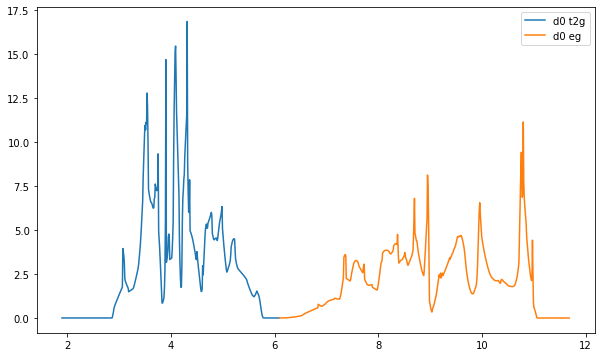

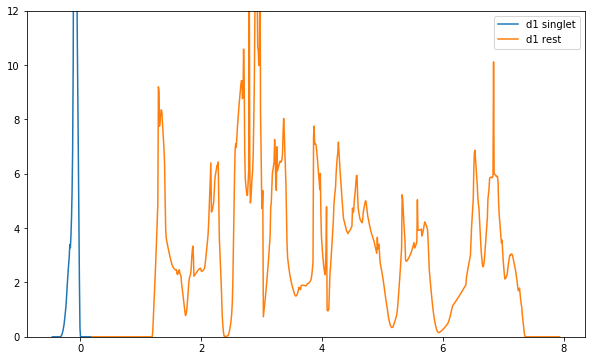

In [56]:
start = 1150
end = 1220

# print(f'd1 - {integrate(axes[-1], start, end)}')
# print(f'd065 - {integrate(axes[5], 1250, 1350)}')

# spin-polarized (dos is halved) and 2 Ta per f.u., 2 f.u. per u.c. 
line_idx = 2

print('NOTE: The total is 12 states because the POTCAR includes the 6s1 state')

fig = pyplot.figure(figsize=(10,6))
print(f'd0 t2g? - {integrate(axes[0], line_idx, 1300, 1750, label="d0 t2g")*2/4} states/Ta')
print(f'd0 eg? - {integrate(axes[0], line_idx, 1750, 2350, label="d0 eg")*2/4} states/Ta')

fig = pyplot.figure(figsize=(10,6))
print(f'd1 singlet - {integrate(axes[-1], line_idx, 1150, 1220, label="d1 singlet")*2/4} states/Ta')
print(f'd1 rest - {integrate(axes[-1], line_idx, 1220, 2050, label="d1 rest")*2/4} states/Ta')
pyplot.ylim([0,12])